# Text classifiction

# Step [1]: Prepare libraries and data

## [1.1] Include important libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import nltk
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt         
from wordcloud import WordCloud

## [1.2] Download data

In [ ]:
# !wget 'https://drive.google.com/uc?export=download&id=1KepfzAhJ7dloG8XaWQf0ovQipDHYS8aI' -O 'final_data.zip'

In [ ]:
# !unzip final_data.zip

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## [1.3] read data from csv file

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/NLP H1/train.csv",encoding='utf-8')# shearch for  encoding='utf-8'
test = pd.read_csv("/content/drive/MyDrive/NLP H1/test.csv",encoding='utf-8')
data.tail()

,tweet,label
19352,الهند تكسر رقم جديد من حيث الاصابات بالوباء 8...,3
19353,#جنوب_أفريقيا تبيع لقاح « #استرازينيكا » المضا...,3
19354,منظمة الصحة العالمية: سلالة كورونا الجديدة الم...,3
19355,#توزيع_فوط_مجانا #زواج_وليد_الشمري #جايه_معاك...,2
19356,@bint__althani وزير الصحة البريطاني فيروس جديد...,2


## [1.4] Prapere The Comparison Dictionary

In [ ]:
model_comparison_table = {}

In [ ]:
model_comparison_table['model_name'] = []
model_comparison_table['preprocessing_methods'] = []
model_comparison_table['accuracy'] = []

In [ ]:
def add_to_dictionary(model_name,preprocessing_methods,accuracy):  
    """add detaisl to dictionary"""
    model_comparison_table['model_name'].append(model_name)
    model_comparison_table['preprocessing_methods'].append(preprocessing_methods)
    model_comparison_table['accuracy'].append(accuracy)


# Step [2]:  Discover and visualize the data

## [2.1]: Data discovery

In [ ]:
data.shape

(19357, 2)

In [ ]:
data.head()

,tweet,label
0,#تبني_قطط_انقاذ من الخاص هاااام كيتن أنثى عمره...,2
1,'#خذ_الخطوة_خذ_اللقاح \nالحمدالله من قبل ومن ب...,1
2,لو اللي مثلك وشرواك طعمو كان قد حذفنا الكمامات...,1
3,#الصحة:•نحو 14.5 مليون شخص تم إعطاؤهم جرعة لقا...,1
4,• في منظور القوة البشرية ( الأزمة ستطول لأشهر ...,3


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19357 entries, 0 to 19356
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   19356 non-null  object
 1   label   19357 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 302.6+ KB


In [ ]:
data['label'].unique()

array([2, 1, 3, 0])

In [ ]:
data['label'].value_counts() 

3    7338
1    5334
2    3902
0    2783
Name: label, dtype: int64

In [ ]:
data.isna().sum()

tweet    1
label    0
dtype: int64

## [2.2]: Data visualization¶

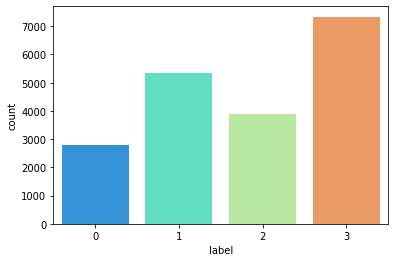

In [ ]:
sns.countplot(x='label',data=data,palette='rainbow')

# Step [3]:  Preprocess for data¶

## [3.1]: Data Cleaning

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.isna().sum()

tweet    0
label    0
dtype: int64

## [3.2]: Remove url and mintion and hashtags

In [ ]:
def remove_url(tweet):

    # remove URL
    tweet = re.sub('https?\S+', ' ', tweet)
    
    # Remove usernames
    tweet = re.sub(r"@\S+",'',tweet)
    
    
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    
      ## remove extra whitespace
    tweet = re.sub('\s+', ' ', tweet) 
    
    tweet = re.sub('^[\u0621-\u064A\u0660-\u0669 ]+$', '', tweet)
    tweet = re.sub('\.+', '', tweet)
    tweet = re.sub(':', '', tweet)
    tweet = re.sub('!', '', tweet)
    tweet = re.sub('،','',tweet)
    tweet = re.sub('-',' ',tweet)
    tweet = re.sub('_',' ',tweet)
    
    
    return tweet

In [ ]:
print(data['tweet'][0])
print('_____________________________________________________________________________________________________')
remove_url(data['tweet'][0])

#تبني_قطط_انقاذ من الخاص هاااام كيتن أنثى عمرها ٥٩ يوم اخذتها حديثه الولاده عمرها ٣ ايام تم التطعيم امس سبب العرض للتبني انا اعتني بالقطط حديثه الولاده  وعند اكتمال شهرين يحتاجوا مساحة  وانا ما عندي هادي لوجود اكثر من ٧ قطط حديثه الولاده للتواصل @saad28234346 التبني الرياض 
_____________________________________________________________________________________________________


'تبني قطط انقاذ من الخاص هاااام كيتن أنثى عمرها ٥٩ يوم اخذتها حديثه الولاده عمرها ٣ ايام تم التطعيم امس سبب العرض للتبني انا اعتني بالقطط حديثه الولاده وعند اكتمال شهرين يحتاجوا مساحة وانا ما عندي هادي لوجود اكثر من ٧ قطط حديثه الولاده للتواصل التبني الرياض '

## [3.3]: Remove emoji

In [ ]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r'', tweet)
    return tweet

In [ ]:
print(data['tweet'][7])
print('_____________________________________________________________________________________________________')
remove_emoji(data['tweet'][7])

🚨السلطات الصحية تعلن تطعيم أكثر من نصف مليون طفل في الفئة العمرية [12-17] بلقاح فيروس كورونا في أنحاء البلاد بعد أقل من أسبوع على بدء تطعيم هذه الفئة https://t.co/XbqFBwGEYI
_____________________________________________________________________________________________________


'السلطات الصحية تعلن تطعيم أكثر من نصف مليون طفل في الفئة العمرية [12-17] بلقاح فيروس كورونا في أنحاء البلاد بعد أقل من أسبوع على بدء تطعيم هذه الفئة https://t.co/XbqFBwGEYI'

## [3.4]: Remove Stopwords

In [ ]:
def remove_stepwords(tweet):
    stop_words=nltk.corpus.stopwords.words("arabic")
    t = " ".join([w for w in str(tweet).split() if not w in stop_words])
    return t

In [ ]:
print(data['tweet'][1])
print('_____________________________________________________________________________________________________')
remove_stepwords(data['tweet'][1])

'#خذ_الخطوة_خذ_اللقاح \nالحمدالله من قبل ومن بعد أخذت اليوم \nالجرعه الأولى من لقاح #فيروس_كورونا\nأسأل الله أن يجعل فيه العافيه وأن يزيل \nعن هذا الوباء عاجلا غير آجل. https://t.co/nG1D24s5Bx'
_____________________________________________________________________________________________________


"'#خذ_الخطوة_خذ_اللقاح \\nالحمدالله أخذت اليوم \\nالجرعه الأولى لقاح #فيروس_كورونا\\nأسأل الله يجعل العافيه وأن يزيل \\nعن الوباء عاجلا آجل. https://t.co/nG1D24s5Bx'"

## [3.5]: Create a Train Set and test Set¶

In [ ]:
train = data[(data['label'] < 2)]
data_test = test[(test['label'] < 2)]
train.tail()

,tweet,label
19342,"#جونسون: لقاح ""#أسترازينيكا"" آمن وسآخذ جرعتي م...",1
19343,@nfnfjo اذا من خططهم قتلنا باللقاح و افساد الا...,0
19347,واللهِ من يوم ما أخدت اللقاح وجسمي مش مني بس ب...,0
19348,لعودة_آمنة لمدارسنا .. نبادر بأخذ الجرعتين من ...,1
19350,هل ستأخذ لقاح #كوفيد19 أو تعرف من سيفعل؟ ✌ علي...,1


In [ ]:
y_train = train['label']
X_train = train.drop('label',axis=1)
y_test = data_test['label']
X_test = data_test.drop('label',axis=1)

In [ ]:
X_test.shape

(2717, 1)

In [ ]:
X_train.shape

(8117, 1)

# Step [4]: ML Model

## [4.1]: Baseline Model¶

### [4.1.1]:  Extract Bag of Words Features

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))
train= vectorizer.fit_transform(X_train["tweet"].values)
test  = vectorizer.transform(X_test["tweet"].values)
train

<8117x176033 sparse matrix of type '<class 'numpy.int64'>'
	with 386826 stored elements in Compressed Sparse Row format>

### [4.1.2]: Train model LogisticRegression classifaiter

In [ ]:
from sklearn.linear_model import LogisticRegression
# y_train = y_train.values
# y_test = y_test.values

classifier = LogisticRegression(max_iter=500)
classifier.fit(train, y_train)


LogisticRegression(max_iter=500)

### [4.1.3] Evaluation

In [ ]:
Accuracy = classifier.score(test, y_test)

print("Accuracy:", Accuracy)

Accuracy: 0.7835848362164152


In [ ]:
add_to_dictionary("logistic regression with bag of words","none",Accuracy)

## [4.2]: Build model with preprocessing methods

In [ ]:
def bow_and_LogisticRegression(x_train,x_test):
    vectorizer = CountVectorizer()
    train= vectorizer.fit_transform(x_train["tweet"].values)
    test  = vectorizer.transform(x_test["tweet"].values)
    
    classifier = LogisticRegression(max_iter=500)
    classifier.fit(train, y_train)
    
    Accuracy = classifier.score(test, y_test)
    return Accuracy

### [4.2.1]: Remove url and mintion and hashtags with BOW and LogisticRegression classifaiter

In [ ]:
x_train = pd.DataFrame()
x_test = pd.DataFrame()

In [ ]:
x_train["tweet"] = X_train["tweet"].apply(remove_url)
x_test["tweet"] = X_test["tweet"].apply(remove_url)

In [ ]:
Accuracy = bow_and_LogisticRegression(x_train,x_test)
Accuracy

0.749723960250276

In [ ]:
add_to_dictionary("logistic regression with bag of words","remove url and mintion and hashtags",Accuracy)

### [4.2.2]: Remove emoji BOW and LogisticRegression classifaiter

In [ ]:
x_train["tweet"] = X_train["tweet"].apply(remove_emoji)
x_test["tweet"] = X_test["tweet"].apply(remove_emoji)

In [ ]:
Accuracy = bow_and_LogisticRegression(x_train,x_test)
Accuracy

0.7754876702245124

In [ ]:
add_to_dictionary("logistic regression with bag of words","remove emoji",Accuracy)

### [4.2.3]: Remove stopwords, BOW and LogisticRegression classifaiter

In [ ]:
x_train["tweet"] = X_train["tweet"].apply(remove_stepwords)
x_test["tweet"] = X_test["tweet"].apply(remove_stepwords)

In [ ]:
Accuracy = bow_and_LogisticRegression(x_train,x_test)
Accuracy

0.7747515642252485

In [ ]:
add_to_dictionary("logistic regression with bag of words","remove stopwords",Accuracy)

## [4.3]: Ngrams BOW and LogisticRegression classifaiter

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2))
train= vectorizer.fit_transform(X_train["tweet"].values)
test  = vectorizer.transform(X_test["tweet"].values)
train

<8117x176033 sparse matrix of type '<class 'numpy.int64'>'
	with 386826 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=500)
classifier.fit(train, y_train)


LogisticRegression(max_iter=500)

In [ ]:
Accuracy = classifier.score(test, y_test)

print("Accuracy:", Accuracy)

Accuracy: 0.7835848362164152


In [ ]:
add_to_dictionary("logistic regression with ngrams bag of words","none",Accuracy)

## [4.4]: TF-IDF and LogisticRegression classifaiter

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_LogisticRegression(x_train,x_test,min_f,max_f):
    
    tfidf_vectorizer = TfidfVectorizer(min_df=min_f, max_df=max_f, ngram_range=(1, 2))
    x_train = tfidf_vectorizer.fit_transform(x_train["tweet"].values)
    x_test =tfidf_vectorizer.transform(x_test["tweet"].values)
    
    classifier = LogisticRegression(max_iter=500)
    classifier.fit(x_train, y_train)
    Accuracy = classifier.score(x_test, y_test)
    return Accuracy


In [ ]:
Accuracy = tfidf_LogisticRegression(X_train,X_test,20,0.5)                                                                      
Accuracy

0.7464114832535885

In [ ]:
add_to_dictionary("logistic regression with TD-IDF","none",Accuracy)

##[4.5] k-Nearest Neighbors with BOW

In [ ]:
## k-Nearest Neighbors

In [ ]:
vectorizer = CountVectorizer()
train= vectorizer.fit_transform(X_train["tweet"].values)
test  = vectorizer.transform(X_test["tweet"].values)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [ ]:
Accuracy = knn.score(test, y_test)
Accuracy

0.666912035333088

In [ ]:
add_to_dictionary(" k-Nearest Neighbors  with BOW","none",Accuracy)

##[4.6] SGDClassifier with tf-idf

In [ ]:
## k-Nearest Neighbors

In [ ]:

tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train = tfidf_vectorizer.fit_transform(X_train["tweet"].values)
test =tfidf_vectorizer.transform(X_test["tweet"].values)
    

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(train, y_train)

SGDClassifier(random_state=42)

In [ ]:
Accuracy = sgd_clf.score(test, y_test)
Accuracy

0.7876334192123666

In [ ]:
add_to_dictionary(" SGDClassifier  with tf-idf","none",Accuracy)

## [4.7]: RandomForestClassifier with BOW

In [ ]:
vectorizer = CountVectorizer()
train= vectorizer.fit_transform(X_train["tweet"].values)
test  = vectorizer.transform(X_test["tweet"].values)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
orest_clf = RandomForestClassifier(random_state=42)
orest_clf.fit(train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
Accuracy = orest_clf.score(test, y_test)
Accuracy

0.742730953257269

In [ ]:
add_to_dictionary(" SGDClassifier  with tf-idf","none",Accuracy)

# Step [5]: DeepLearning Model

## [5.1]: Simple NN model with BOW

In [ ]:
vectorizer = CountVectorizer()
train = vectorizer.fit_transform(X_train["tweet"].values)
test = vectorizer.transform(X_test["tweet"].values)
    

In [ ]:
input_dim = train.shape[1]  

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(tf.keras.layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4264200   
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,265,221
Trainable params: 4,265,221
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, y_train,
                     epochs=25,
                     verbose=False,
                     batch_size=10,
                     validation_data=(test, y_test))

InvalidArgumentError: ignored

In [ ]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

# Step[6]: class all data with SGD classtier and tf-idf

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/NLP H1/train.csv",encoding='utf-8')# shearch for  encoding='utf-8'
test = pd.read_csv("/content/drive/MyDrive/NLP H1/test.csv",encoding='utf-8')


In [ ]:
train.dropna(inplace=True)

In [ ]:
y_train = train['label']
X_train = train.drop('label',axis=1)
y_test = test['label']
X_test = test.drop('label',axis=1)

In [ ]:

tfidf_vectorizer = CountVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train = tfidf_vectorizer.fit_transform(X_train["tweet"].values)
test =tfidf_vectorizer.transform(X_test["tweet"].values)
    

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(train, y_train)

SGDClassifier(random_state=42)

In [ ]:
Accuracy = sgd_clf.score(test, y_test)
Accuracy

0.5734655920644761

In [ ]:
add_to_dictionary(" SGDClassifier  with tf-idf","none",Accuracy)

# Step[7]: the Ruselt

In [ ]:
df = pd.DataFrame(model_comparison_table)
df

,model_name,preprocessing_methods,accuracy
0,logistic regression with bag of words,none,0.783585
1,logistic regression with bag of words,remove url and mintion and hashtags,0.749724
2,logistic regression with bag of words,remove emoji,0.775488
3,logistic regression with bag of words,remove stopwords,0.774752
4,logistic regression with ngrams bag of words,none,0.783585
5,logistic regression with TD-IDF,none,0.746411
6,k-Nearest Neighbors with BOW,none,0.666912
7,SGDClassifier with tf-idf,none,0.787633
8,SGDClassifier with tf-idf,none,0.742731
9,SGDClassifier with tf-idf,none,0.573466


In [ ]:
df.to_csv("[ريما السهلي].csv", index=False)